# Impor packages

In [1]:
# pip install pandas
# pip install numpy
# pip install datetime
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
import os
os.getcwd()

'/content'

# Impor data dari CSV ke DataFrame

In [4]:
df = pd.read_csv('Salinan Online Retail Data.csv', header=0)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5.0,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1.0,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5.0,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1.0,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1.0,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
411963,535416,22080,RIBBON REEL POLKADOTS,10.0,2010-11-26 11:40:00,1.65,14312.0
411964,535416,22113,GREY HEART HOT WATER BOTTLE,4.0,2010-11-26 11:40:00,3.75,14312.0
411965,535416,84881,BLUE WIRE SPIRAL CANDLE HOLDER,2.0,2010-11-26 11:40:00,6.35,14312.0
411966,535416,21485,RETROSPOT HEART HOT WATER BOTTLE,3.0,2010-11-26 11:40:00,4.95,14312.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411968 entries, 0 to 411967
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      411968 non-null  object 
 1   product_code  411967 non-null  object 
 2   product_name  409391 non-null  object 
 3   quantity      411967 non-null  float64
 4   order_date    411967 non-null  object 
 5   price         411967 non-null  float64
 6   customer_id   328323 non-null  float64
dtypes: float64(3), object(4)
memory usage: 22.0+ MB


# Data cleansing

In [7]:
df_clean = df.copy()
# mengkonversi kolom order_date menjadi datetime
df_clean['order_date'] = df_clean['order_date'].astype('datetime64[ns]')
# membuat kolom year_month
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')
# menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]
# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]
# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()
# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]
# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')
# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()
# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]
# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)
# menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

<ipython-input-7-35f4919c297c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['amount'] = df_clean['quantity'] * df_clean['price']


,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1.0,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,red retrospot mug,36.0,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12.0,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2.0,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2.0,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
326107,535416,22082,ribbon reel stripes design,10.0,2010-11-26 11:40:00,1.65,14312.0,2010-11,delivered,16.50
326108,535416,22080,ribbon reel spots design,10.0,2010-11-26 11:40:00,1.65,14312.0,2010-11,delivered,16.50
326109,535416,22113,grey heart hot water bottle,4.0,2010-11-26 11:40:00,3.75,14312.0,2010-11,delivered,15.00
326110,535416,84881,blue wire spiral candle holder,2.0,2010-11-26 11:40:00,6.35,14312.0,2010-11,delivered,12.70


In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326112 entries, 0 to 326111
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      326112 non-null  object        
 1   product_code  326112 non-null  object        
 2   product_name  326112 non-null  object        
 3   quantity      326112 non-null  float64       
 4   order_date    326112 non-null  datetime64[ns]
 5   price         326112 non-null  float64       
 6   customer_id   326112 non-null  object        
 7   year_month    326112 non-null  period[M]     
 8   order_status  326112 non-null  object        
 9   amount        326112 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5), period[M](1)
memory usage: 24.9+ MB


# Membuat user retention cohort

## Agregat data transaksi ke bentuk summary total transaksi/order setiap pengguna setiap bulan

In [9]:
df_user_monthly = df_clean.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1
...,...,...,...
11044,18286.0,2010-06,1
11045,18286.0,2010-08,1
11046,18287.0,2010-05,1
11047,18287.0,2010-09,2


## Buat kolom sebagai cohort dari pengguna, misal cohort bulan pertama kali bertransaksi

In [10]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
11044,18286.0,2010-06,1,2010-06
11045,18286.0,2010-08,1,2010-06
11046,18287.0,2010-05,1,2010-05
11047,18287.0,2010-09,2,2010-05


## Hitung jarak bulan antara bulan transaksi dengan bulan pertama kali transaksi dan jumlahkan dengan 1 agar jarak bulan 0 menjadi 1 yang berarti bulan pertama, dst.

In [11]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
11044,18286.0,2010-06,1,2010-06,1
11045,18286.0,2010-08,1,2010-06,3
11046,18287.0,2010-05,1,2010-05,1
11047,18287.0,2010-09,2,2010-05,5


## Tabel pivot dengan index berupa cohort, kolom berupa jarak bulan, dan nilainya adalah banyaknya pengguna unik (count unique dari ID pengguna)

In [12]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,
2010-01,713.0,280.0,334.0,313.0,305.0,304.0,293.0,268.0,285.0,319.0,312.0
2010-02,461.0,154.0,128.0,161.0,152.0,121.0,119.0,159.0,153.0,155.0,NaN
2010-03,528.0,147.0,159.0,145.0,140.0,123.0,149.0,186.0,175.0,NaN,NaN
2010-04,326.0,82.0,75.0,63.0,69.0,79.0,98.0,92.0,NaN,NaN,NaN
2010-05,274.0,55.0,50.0,52.0,52.0,72.0,61.0,NaN,NaN,NaN,NaN
2010-06,266.0,53.0,56.0,60.0,65.0,71.0,NaN,NaN,NaN,NaN,NaN
2010-07,179.0,38.0,37.0,52.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,227.0,64.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Hitung banyaknya pengguna di masing-masing cohort (pengguna yang pertama kali transaksi di bulan tersebut) dan bagi semua nilai di tabel pivot tadi dengan nilai tersebut sebagai retention rate

In [13]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

,1
cohort,
2010-01,713.0
2010-02,461.0
2010-03,528.0
2010-04,326.0
2010-05,274.0
2010-06,266.0
2010-07,179.0
2010-08,160.0
2010-09,227.0


In [14]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.437588
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.344902,0.331887,0.336226,NaN
2010-03,1.0,0.278409,0.301136,0.274621,0.265152,0.232955,0.282197,0.352273,0.331439,NaN,NaN
2010-04,1.0,0.251534,0.230061,0.193252,0.211656,0.242331,0.300613,0.282209,NaN,NaN,NaN
2010-05,1.0,0.200730,0.182482,0.189781,0.189781,0.262774,0.222628,NaN,NaN,NaN,NaN
2010-06,1.0,0.199248,0.210526,0.225564,0.244361,0.266917,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.212291,0.206704,0.290503,0.268156,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.287500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.281938,0.246696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tampilkan tabel pivot yang sudah berisi nilai retention rate tersebut dalam heatmap

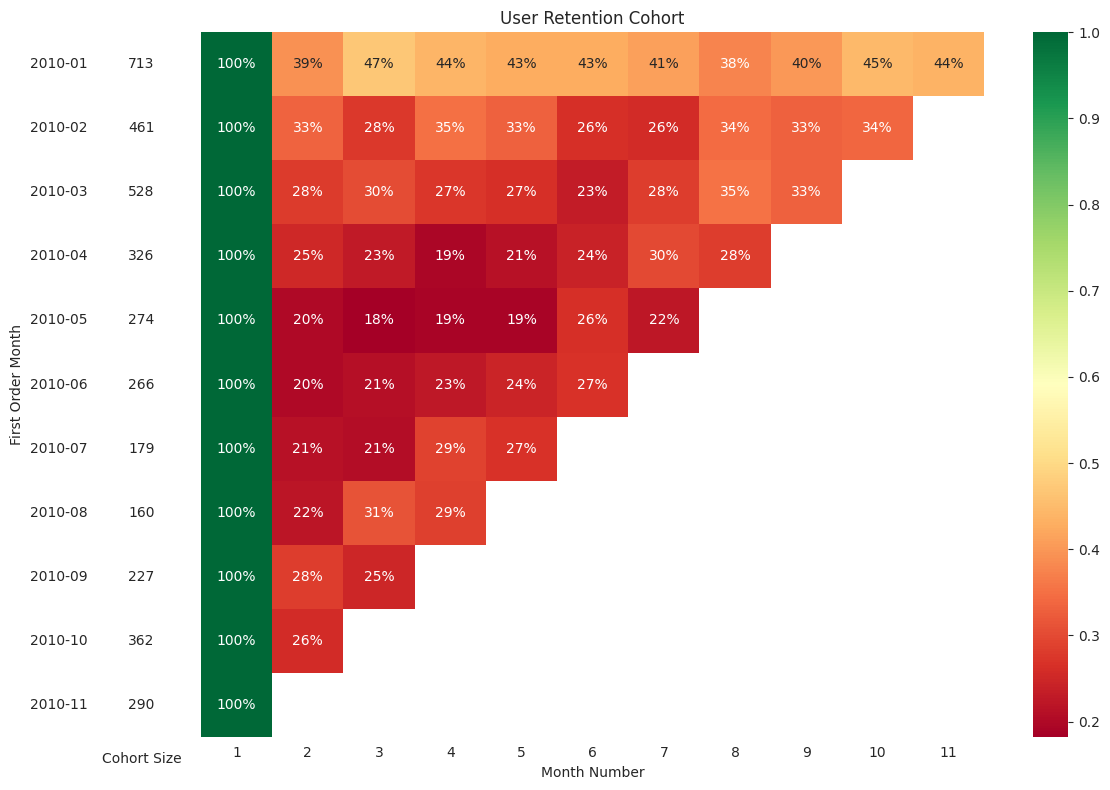

In [15]:
# pip install matplotlib
# pip install seaborn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()